In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, Normalize
from matplotlib import patches
import seaborn as sns
import re
import string
import cellbayesassay as cba
import attila_utils

## Fitted dose-respones data

In [2]:
TI2name = pd.read_excel('../../resources/cell-based-assays/study-TI-to-name.xlsx', index_col=[0, 1])['name']
TI2name_df = pd.read_excel('../../resources/cell-based-assays/study-TI-to-name.xlsx').drop('long name', axis=1)
TI2name_df

,study,TI,name
0,CO25360,TI1,Valproic acid
1,CO25360,TI2,Salbutamol
2,CO25360,TI3,Sildenafil
3,CO25360,TI4,Probenecid
4,CO25360,TI5,Montelukast
5,CO25360,TI6,Felodipine
6,CO25360,TI7,Levetiracetam
7,CO25360,TI8,Nifedipine
8,CO25360,TI9,Acitretin
9,CO25360,TI10,Dasatinib


In [3]:
idatadf1 = cba.idatadf_from_netcdf(subdir='idatadf/', maindir='../../results/2023-09-26-cell-bayes-assays/')

In [4]:
idatas2 = cba.idatas_from_netcdf(subdir='idatas/', maindir='../../results/2024-02-14-cell-bayes/')

In [5]:
idatas3 = cba.idatas_from_netcdf(subdir='idatas/', maindir='../../results/2024-04-21-cell-bayes/')

In [6]:
idatas4 = cba.idatas_from_netcdf(subdir='idatas/', maindir='../../results/2024-04-29-cell-bayes/')

In [7]:
idatas1 = pd.DataFrame(idatadf1.to_numpy(), index=idatadf1.index, columns=pd.MultiIndex.from_product([['CO25360'], idatadf1.columns])).stack(level=[0, 1])
idatas1 = idatas1.reorder_levels([2, 0, 1, 3])
idatas1 = pd.Series(idatas1.to_numpy(), index=idatas1.index.set_names(['study', 'experiment', 'assay', 'TI']))
idatas = pd.concat([idatas1, idatas2, idatas3, idatas4])
idatas = idatas.loc[~ idatas.index.duplicated(keep='first')]
idatas

study    experiment                assay    TI  
CO25360  Aβ clearance (BV2 cells)  Aβ42 Ly  TI21    (posterior, log_likelihood, sample_stats, obse...
                                            TI22    (posterior, log_likelihood, sample_stats, obse...
                                            TI26    (posterior, log_likelihood, sample_stats, obse...
                                   Aβ42 SN  TI21    (posterior, log_likelihood, sample_stats, obse...
                                            TI22    (posterior, log_likelihood, sample_stats, obse...
                                                                          ...                        
         Aβ release (H4 cells)     Aβ42     TI5     (posterior, log_likelihood, sample_stats, obse...
                                            TI6     (posterior, log_likelihood, sample_stats, obse...
                                            TI7     (posterior, log_likelihood, sample_stats, obse...
                                 

<Axes: xlabel='study-TI', ylabel='experiment-assay'>

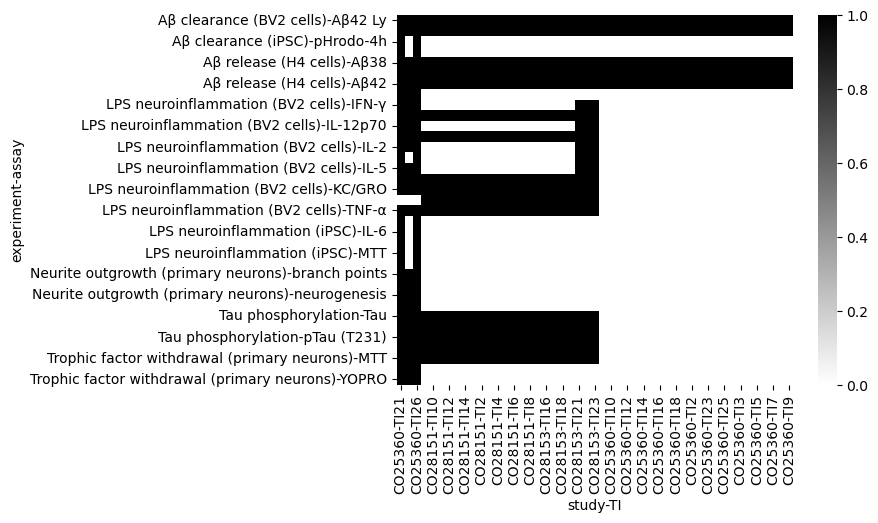

In [8]:
received = idatas.unstack(level=[0, 3]).map(lambda x: not pd.isna(x))
received
fig, ax = plt.subplots()
sns.heatmap(received, ax=ax, cmap='binary')

## Posteriors and Bayes factors

In [9]:
fpathl = [
    '../../results/2023-09-26-cell-bayes-assays/H102_posteriors.csv',
    #'../../results/2024-02-14-cell-bayes/H102_posteriors.csv',
    #'../../results/2024-01-21-cell-bayes-assays-dim/H102_posteriors.csv'
]
l = [pd.read_csv(fpath, index_col=[0, 1], header=[0, 1]) for fpath in fpathl]
H102_posteriors1 = pd.concat([l[0]], axis=1)
#H102_posteriors1 = pd.concat([l[0], l[1].drop('Arundine', level=0, axis=1)], axis=1)
H102_posteriors1 = H102_posteriors1.stack(level=0)
H102_posteriors1['name'] = H102_posteriors1.index.get_level_values(2)
name2TI = {
    'TUDCA': ('CO25360', 'TI21'),
    'Cysteamine': ('CO25360', 'TI22'),
    'Arundine': ('CO25360', 'TI26'),
    'C-DIM5': ('CO28151', 'TI11'),
    'C-DIM12': ('CO28151', 'TI12'),
}
l = [H102_posteriors1.name.apply(lambda x: name2TI[x][i]).to_frame(c) for i, c in zip(range(2), ['study', 'TI'])]
ixdf = pd.concat([l[0], H102_posteriors1.index.to_frame().iloc[:, :-1].rename({0: 'experiment', 1:'assay'}, axis=1), l[1]], axis=1)
H102_posteriors1 = pd.DataFrame(H102_posteriors1.to_numpy(), index=pd.MultiIndex.from_frame(ixdf), columns=H102_posteriors1.columns.to_list())
H102_posteriors1

H1  \
study   experiment                                  assay   TI              
CO25360 Aβ clearance (BV2 cells)                    Aβ42 Ly TI26    0.879   
                                                            TI22      0.0   
                                                            TI21  0.99275   
                                                    Aβ42 SN TI26    0.373   
                                                            TI22    0.002   
...                                                                   ...   
        Trophic factor withdrawal (primary neurons) PI      TI22  0.00075   
                                                            TI21  0.00025   
                                                    YOPRO   TI26   0.0005   
                                                            TI22      0.0   
                                                            TI21  0.00875   

                                                                       H0  \
study   experiment                                  assay   TI              
CO25360 Aβ clearance (BV2 cells)                    Aβ42 Ly TI26     0.12   
                                                            TI22      0.0   
                                                            TI21  0.00725   
                                                    Aβ42 SN TI26   0.6255   
                                                            TI22  0.18175   
...                                                                   ...   
        Trophic factor withdrawal (primary neurons) PI      TI22  0.98275   
                                                            TI21  0.93475   
                                                    YOPRO   TI26    0.977   
                                                            TI22  0.95175   
                                                            TI21  0.97275   

                                                                       H2  \
study   experiment                                  assay   TI              
CO25360 Aβ clearance (BV2 cells)                    Aβ42 Ly TI26    0.001   
                                                            TI22      1.0   
                                                            TI21      0.0   
                                                    Aβ42 SN TI26   0.0015   
                                                            TI22  0.81625   
...                                                                   ...   
        Trophic factor withdrawal (primary neurons) PI      TI22   0.0165   
                                                            TI21    0.065   
                                                    YOPRO   TI26   0.0225   
                                                            TI22  0.04825   
                                                            TI21   0.0185   

                                                                        name  
study   experiment                                  assay   TI                
CO25360 Aβ clearance (BV2 cells)                    Aβ42 Ly TI26    Arundine  
                                                            TI22  Cysteamine  
                                                            TI21       TUDCA  
                                                    Aβ42 SN TI26    Arundine  
                                                            TI22  Cysteamine  
...                                                                      ...  
        Trophic factor withdrawal (primary neurons) PI      TI22  Cysteamine  
                                                            TI21       TUDCA  
                                                    YOPRO   TI26    Arundine  
                                                            TI22  Cysteamine  
                                                            TI21       TUDCA  

[91 rows x 4 columns]

In [10]:
H102_posteriors2 = pd.read_csv('../../results/2024-02-14-cell-bayes/H102_posteriors.csv', index_col=list(range(4)))
H102_posteriors3 = pd.read_csv('../../results/2024-04-21-cell-bayes/H102_posteriors.csv', index_col=list(range(4)))
H102_posteriors4 = pd.read_csv('../../results/2024-04-29-cell-bayes/H102_posteriors.csv', index_col=list(range(4)))
H102_posteriors = pd.concat([H102_posteriors1, H102_posteriors2, H102_posteriors3, H102_posteriors4], axis=0)
H102_posteriors = H102_posteriors.loc[~ H102_posteriors.index.duplicated(keep='first')]
H102_posteriors

H1       H0       H2  \
study   experiment               assay   TI                                
CO25360 Aβ clearance (BV2 cells) Aβ42 Ly TI26    0.879     0.12    0.001   
                                         TI22      0.0      0.0      1.0   
                                         TI21  0.99275  0.00725      0.0   
                                 Aβ42 SN TI26    0.373   0.6255   0.0015   
                                         TI22    0.002  0.18175  0.81625   
...                                                ...      ...      ...   
        Aβ release (H4 cells)    Aβ42    TI20    0.572  0.42725  0.00075   
                                         TI23  0.08125  0.91425   0.0045   
                                         TI24  0.09825  0.89575    0.006   
                                         TI25  0.00625   0.9645  0.02925   
                                         TI27  0.01575  0.94225    0.042   

                                                        name  
study   experiment               assay   TI                   
CO25360 Aβ clearance (BV2 cells) Aβ42 Ly TI26       Arundine  
                                         TI22     Cysteamine  
                                         TI21          TUDCA  
                                 Aβ42 SN TI26       Arundine  
                                         TI22     Cysteamine  
...                                                      ...  
        Aβ release (H4 cells)    Aβ42    TI20     MTS-III-25  
                                         TI23     Rifampicin  
                                         TI24    Mebendazole  
                                         TI25  Pyrimethamine  
                                         TI27    HCQ + TUDCA  

[578 rows x 4 columns]

In [11]:
BF10 = cba.BF10_from_H102_posteriors_long(cba.pseudocount_to_H102_posteriors(H102_posteriors), merge_H0_H2=True)
BF10 = pd. concat([BF10, idatas.apply(lambda x: not pd.isna(x)).to_frame('received')], axis=1)
vmin = BF10['2 log BF'].min()
vmax = BF10['2 log BF'].max()
BF10['2 log BF'] = BF10.apply(lambda r: -1000 if (r.loc['received'] and pd.isna(r.loc['2 log BF'])) else r.loc['2 log BF'], axis=1)
ixdf = BF10.index.to_frame()
ixdf['name'] = ixdf.apply(lambda r: TI2name.loc[(r.loc['study'], r.loc['TI'])], axis=1)
BF10 = pd.DataFrame(BF10.to_numpy(), index=pd.MultiIndex.from_frame(ixdf), columns=BF10.columns)
BF10

Study  \
study   experiment                          assay        TI   name                     
CO25360 Aβ clearance (BV2 cells)            Aβ42 Ly      TI26 Arundine       CO25360   
                                                         TI22 Cysteamine     CO25360   
                                                         TI21 TUDCA          CO25360   
                                            Aβ42 SN      TI26 Arundine       CO25360   
                                                         TI22 Cysteamine     CO25360   
...                                                                              ...   
        Aβ release (H4 cells)               Aβ42         TI25 Pyrimethamine  CO25360   
                                                         TI27 HCQ + TUDCA    CO25360   
        LPS neuroinflammation (BV2 cells)   IFN-γ        TI26 Arundine           NaN   
        Neurite outgrowth (primary neurons) neurogenesis TI22 Cysteamine         NaN   
        Tau phosphorylation                 pT/T ratio   TI26 Arundine           NaN   

                                                                                           Experiment  \
study   experiment                          assay        TI   name                                      
CO25360 Aβ clearance (BV2 cells)            Aβ42 Ly      TI26 Arundine       Aβ clearance (BV2 cells)   
                                                         TI22 Cysteamine     Aβ clearance (BV2 cells)   
                                                         TI21 TUDCA          Aβ clearance (BV2 cells)   
                                            Aβ42 SN      TI26 Arundine       Aβ clearance (BV2 cells)   
                                                         TI22 Cysteamine     Aβ clearance (BV2 cells)   
...                                                                                               ...   
        Aβ release (H4 cells)               Aβ42         TI25 Pyrimethamine     Aβ release (H4 cells)   
                                                         TI27 HCQ + TUDCA       Aβ release (H4 cells)   
        LPS neuroinflammation (BV2 cells)   IFN-γ        TI26 Arundine                            NaN   
        Neurite outgrowth (primary neurons) neurogenesis TI22 Cysteamine                          NaN   
        Tau phosphorylation                 pT/T ratio   TI26 Arundine                            NaN   

                                                                               Assay  \
study   experiment                          assay        TI   name                     
CO25360 Aβ clearance (BV2 cells)            Aβ42 Ly      TI26 Arundine       Aβ42 Ly   
                                                         TI22 Cysteamine     Aβ42 Ly   
                                                         TI21 TUDCA          Aβ42 Ly   
                                            Aβ42 SN      TI26 Arundine       Aβ42 SN   
                                                         TI22 Cysteamine     Aβ42 SN   
...                                                                              ...   
        Aβ release (H4 cells)               Aβ42         TI25 Pyrimethamine     Aβ42   
                                                         TI27 HCQ + TUDCA       Aβ42   
        LPS neuroinflammation (BV2 cells)   IFN-γ        TI26 Arundine           NaN   
        Neurite outgrowth (primary neurons) neurogenesis TI22 Cysteamine         NaN   
        Tau phosphorylation                 pT/T ratio   TI26 Arundine           NaN   

                                                                               TI  \
study   experiment                          assay        TI   name                  
CO25360 Aβ clearance (BV2 cells)            Aβ42 Ly      TI26 Arundine       TI26   
                                                         TI22 Cysteamine     TI22   
                                                         TI21 TUDCA          TI21  

In [12]:
BF10_wide = BF10['2 log BF'].unstack(level=[0, 3, 4]).astype('float64')
BF10_wide

study                                                            CO25360  \
TI                                                                  TI26   
name                                                            Arundine   
experiment                                  assay                          
Aβ clearance (BV2 cells)                    Aβ42 Ly             3.965989   
                                            Aβ42 SN            -1.038736   
Aβ clearance (iPSC)                         pHrodo-4h         -17.974394   
                                            supernatant       -10.394984   
Aβ release (H4 cells)                       Aβ38               -5.259440   
                                            Aβ40               -5.181341   
                                            Aβ42               -5.032100   
Aβ toxicity (primary neurons)               MTT               -16.587599   
LPS neuroinflammation (BV2 cells)           IFN-γ           -1000.000000   
                                            IL-10              -3.869060   
                                            IL-12p70            1.984175   
                                            IL-1β             -13.813510   
                                            IL-2               -7.684018   
                                            IL-4               16.588099   
                                            IL-5                3.257524   
                                            IL-6               -5.365465   
                                            KC/GRO             -1.090217   
                                            MTT                      NaN   
                                            TNF-α              -4.720614   
LPS neuroinflammation (iPSC)                IL-1β              10.305578   
                                            IL-6               12.841493   
                                            IL-8                8.738896   
                                            MTT               -12.425212   
                                            TNF-α               8.085085   
Neurite outgrowth (primary neurons)         branch points     -17.974394   
                                            longest neurite   -13.813510   
                                            neurogenesis      -15.200805   
                                            Σ neurite area    -17.974394   
Tau phosphorylation                         Tau                -1.951358   
                                            pT/T ratio      -1000.000000   
                                            pTau (T231)        -6.724272   
Trophic factor withdrawal (primary neurons) LDH               -17.974394   
                                            MTT               -17.974394   
                                            PI                 -5.847430   
                                            YOPRO             -15.200805   

study                                                                     \
TI                                                                  TI22   
name                                                          Cysteamine   
experiment                                  assay                          
Aβ clearance (BV2 cells)                    Aβ42 Ly           -17.974644   
                                            Aβ42 SN           -12.425212   
Aβ clearance (iPSC)                         pHrodo-4h                NaN   
                                            supernatant              NaN   
Aβ release (H4 cells)                       Aβ38               -4.018215   
                                            Aβ40               -2.377305   
                                            Aβ42               -2.975935   
Aβ toxicity (primary neurons)               MTT                -3.331672   
LPS neuroinflammation (BV2 cells)           IFN-γ             -17.974394   
                                            IL-

['named-figure/cell-based-assays-summary.png',
 'named-figure/cell-based-assays-summary.pdf']

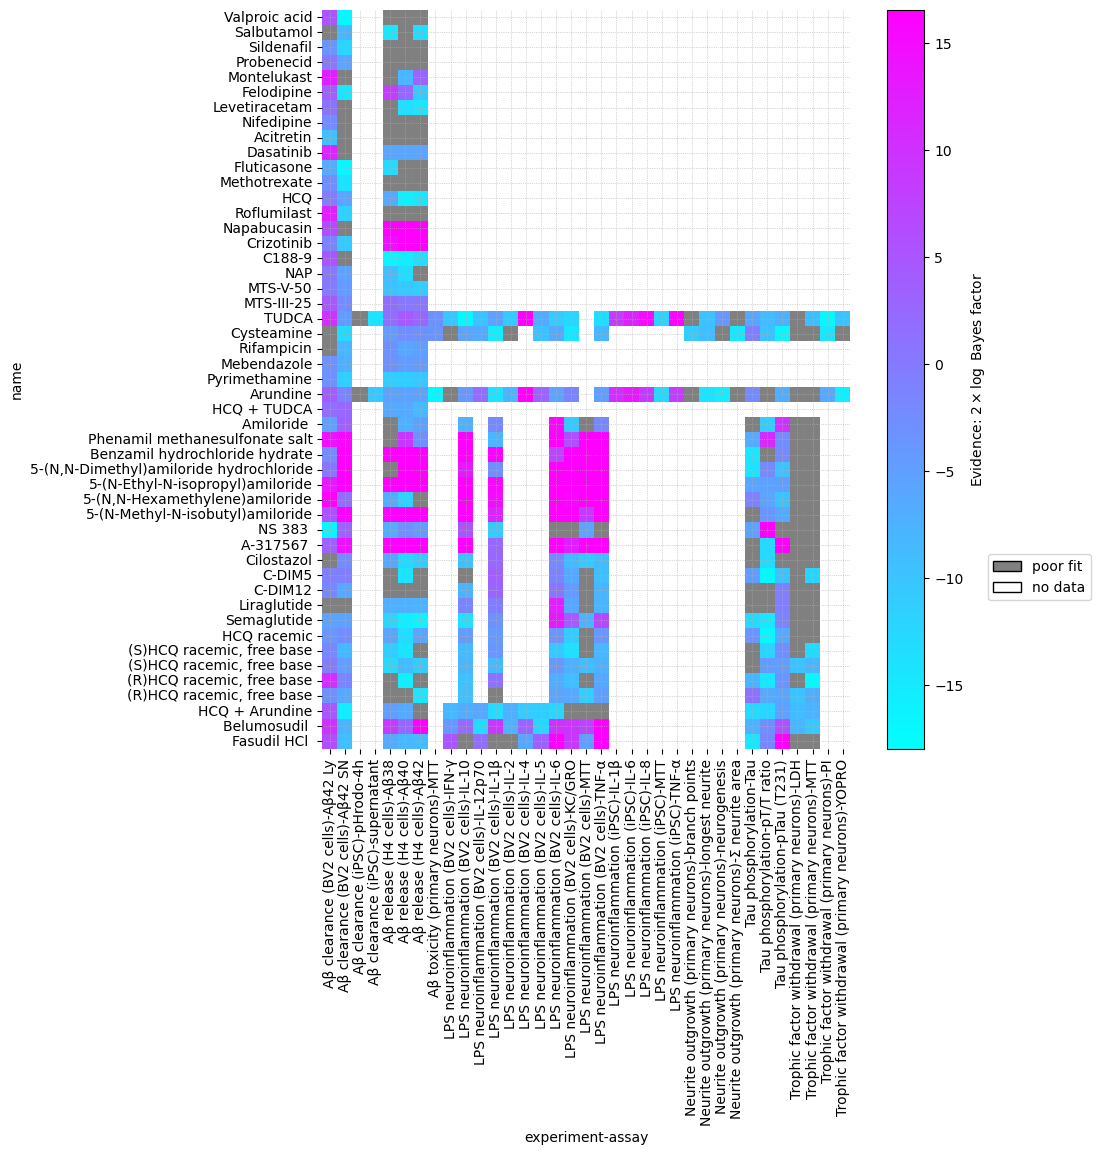

In [13]:
def my_heatmap(data=BF10_wide.reindex(pd.MultiIndex.from_frame(TI2name_df), axis=1).transpose(), vmin=vmin, vmax=vmax):
    cool = matplotlib.colormaps['cool']
    cool_colors = cool(np.linspace(0, 1, 127))
    gray_colors = np.array([[0.5, 0.5, 0.5, 1]])
    my_cmap = ListedColormap(np.concatenate([gray_colors, cool_colors], axis=0))    
    fig, ax = plt.subplots(1, 1, figsize=(9.6, 9.6))
    ax = sns.heatmap(data, ax=ax, cmap=my_cmap, vmin=vmin, vmax=vmax, square=True, cbar=False)
    cbar = fig.colorbar(cm.ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax, clip=False), cmap='cool'), ax=ax, location='right', label=r'Evidence: $2 \times \log$ Bayes factor')
    ax.grid(axis='both', linewidth=0.5, linestyle='dotted')
    rectangles = [patches.Rectangle((0, 0), 10, 10, facecolor=c, edgecolor='k') for c in ['gray', 'white']]
    fig.legend(rectangles, ['poor fit', 'no data'], loc='center right')
    return((fig, ax))

fig, ax = my_heatmap(BF10_wide.reindex(pd.MultiIndex.from_frame(TI2name_df), axis=1).transpose().droplevel([0, 1], axis=0))
attila_utils.savefig(fig, 'cell-based-assays-summary')

In [14]:
fpath = '../../results/2024-04-09-qps-results-summary/cell-based-assays-Bayes-factors.xlsx'
BF10_wide.reindex(pd.MultiIndex.from_frame(TI2name_df), axis=1).transpose().map(lambda x: 'no data' if pd.isna(x) else x).map(lambda x: 'poor fit' if x == -1000 else x).to_excel(fpath)

## Raw data

In [15]:
fpath = '../../resources/cell-based-assays/data-format-specification_NIA_all-CO28151_CO28153.xlsx'
data = pd.read_excel(fpath, sheet_name='Sheet1')
data

,Study,Experiment,Assay,Batch,Plate,TI,Conc,Activity
0,CO28153,LPS neuroinflammation (BV2 cells),IFN-γ,3,1,LPS,NaN,0.043041
1,CO28153,LPS neuroinflammation (BV2 cells),IFN-γ,3,1,LPS,NaN,0.159173
2,CO28153,LPS neuroinflammation (BV2 cells),IFN-γ,3,1,LPS,NaN,0.029069
3,CO28153,LPS neuroinflammation (BV2 cells),IFN-γ,3,1,LPS,NaN,0.134404
4,CO28153,LPS neuroinflammation (BV2 cells),IFN-γ,3,1,LPS,NaN,0.106824
...,...,...,...,...,...,...,...,...
9253,CO28153,Aβ release (H4 cells),Aβ38,2,3,RI,NaN,735.0628
9254,CO28153,Aβ release (H4 cells),Aβ38,2,3,RI,NaN,641.8745
9255,CO28153,Aβ release (H4 cells),Aβ38,2,3,RI,NaN,660.8184
9256,CO28153,Aβ release (H4 cells),Aβ38,2,3,RI,NaN,696.0789


In [16]:
data1 = data[['Study', 'Experiment', 'Assay', 'TI']]
data1 = data1.loc[data1.TI.apply(lambda x: bool(re.match('TI[0-9]{1,2}.*', x)))]
a, exper_assay_raw = [data1.apply(lambda r: tuple(r.to_list()[i:j]), axis=1).unique() for i, j in [[0, 4], [1, 3]]]
s, s1 = [pd.Series(x) for x in [a, exper_assay_raw]]
available_new, available_new1 = [x.apply(lambda t: pd.Series(t)) for x in [s, s1]]
available_new = available_new.rename({0: 'Study', 1: 'Experiment', 2: 'Assay', 3: 'TI'}, axis=1)
available_new1 = available_new1.rename({0: 'Experiment', 1: 'Assay'}, axis=1)
available_new['Available'] = 2
available_new = available_new.set_index(['Study', 'Experiment', 'Assay', 'TI'])
available_new1

,Experiment,Assay
0,LPS neuroinflammation (BV2 cells),IFN-γ
1,LPS neuroinflammation (BV2 cells),IL-10
2,LPS neuroinflammation (BV2 cells),IL-12p70
3,LPS neuroinflammation (BV2 cells),IL-1β
4,LPS neuroinflammation (BV2 cells),IL-6
5,LPS neuroinflammation (BV2 cells),KC/GRO
6,LPS neuroinflammation (BV2 cells),TNF-α
7,Tau phosphorylation,pT/T ratio
8,Tau phosphorylation,pTau (T231)
9,Tau phosphorylation,Tau


In [17]:
available_new.iloc[267:269]

Available
Study   Experiment            Assay TI             
CO28151 Aβ release (H4 cells) Aβ38  TI12          2
                                    TI13          2

In [18]:
exper_assay_pretty = BF10_wide.index.to_frame()[['experiment', 'assay']].apply(lambda r: tuple(r.to_list()), axis=1).unique()
S_pretty = set(exper_assay_pretty)
S_raw = set(exper_assay_raw)
print('Assays missing from the new dataset:')
print(S_pretty.difference(S_raw))
print('Assays missing from the old dataset:')
S_raw.difference(S_pretty)

Assays missing from the new dataset:
{('LPS neuroinflammation (iPSC)', 'IL-6'), ('Aβ clearance (iPSC)', 'pHrodo-4h'), ('Trophic factor withdrawal (primary neurons)', 'YOPRO'), ('LPS neuroinflammation (iPSC)', 'IL-8'), ('Trophic factor withdrawal (primary neurons)', 'PI'), ('LPS neuroinflammation (iPSC)', 'IL-1β'), ('LPS neuroinflammation (iPSC)', 'MTT'), ('Aβ clearance (iPSC)', 'supernatant'), ('Neurite outgrowth (primary neurons)', 'longest neurite'), ('Aβ toxicity (primary neurons)', 'MTT'), ('Neurite outgrowth (primary neurons)', 'Σ neurite area'), ('Neurite outgrowth (primary neurons)', 'neurogenesis'), ('LPS neuroinflammation (iPSC)', 'TNF-α'), ('Neurite outgrowth (primary neurons)', 'branch points')}
Assays missing from the old dataset:


set()

In [19]:
all_exper_assay = pd.DataFrame(np.array([[t[i] for t in list(S_pretty.union(S_raw))] for i in range(2)]).transpose(), columns=['experiment', 'assay'])
all_exper_assay = all_exper_assay.sort_values(['experiment', 'assay'])
all_exper_assay

,experiment,assay
19,Aβ clearance (BV2 cells),Aβ42 Ly
25,Aβ clearance (BV2 cells),Aβ42 SN
10,Aβ clearance (iPSC),pHrodo-4h
27,Aβ clearance (iPSC),supernatant
34,Aβ release (H4 cells),Aβ38
14,Aβ release (H4 cells),Aβ40
20,Aβ release (H4 cells),Aβ42
28,Aβ toxicity (primary neurons),MTT
4,LPS neuroinflammation (BV2 cells),IFN-γ
7,LPS neuroinflammation (BV2 cells),IL-10


['named-figure/cell-based-assays-summary-all.png',
 'named-figure/cell-based-assays-summary-all.pdf']

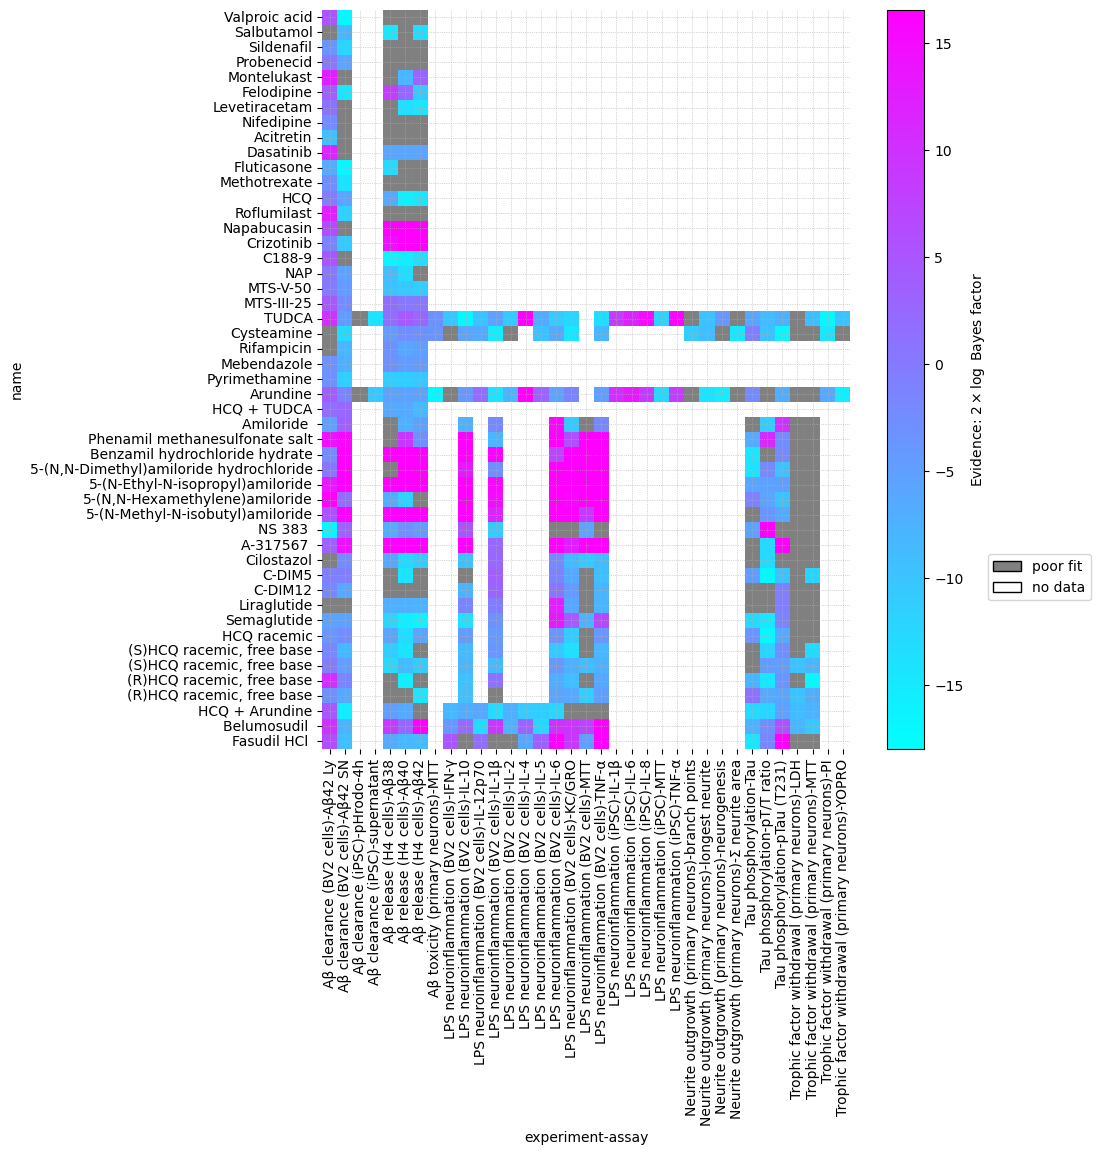

In [20]:
fig, ax = my_heatmap(BF10_wide.reindex(pd.MultiIndex.from_frame(TI2name_df), axis=1).reindex(pd.MultiIndex.from_frame(all_exper_assay), axis=0).transpose().droplevel([0, 1], axis=0))
attila_utils.savefig(fig, 'cell-based-assays-summary-all')

In [21]:
available_old = pd.DataFrame({'Available': 1}, index=idatas.index)
available_old

Available
study   experiment               assay   TI             
CO25360 Aβ clearance (BV2 cells) Aβ42 Ly TI21          1
                                         TI22          1
                                         TI26          1
                                 Aβ42 SN TI21          1
                                         TI22          1
...                                                  ...
        Aβ release (H4 cells)    Aβ42    TI5           1
                                         TI6           1
                                         TI7           1
                                         TI8           1
                                         TI9           1

[581 rows x 1 columns]

['named-figure/presence-in-old-new-datasets.png',
 'named-figure/presence-in-old-new-datasets.pdf']

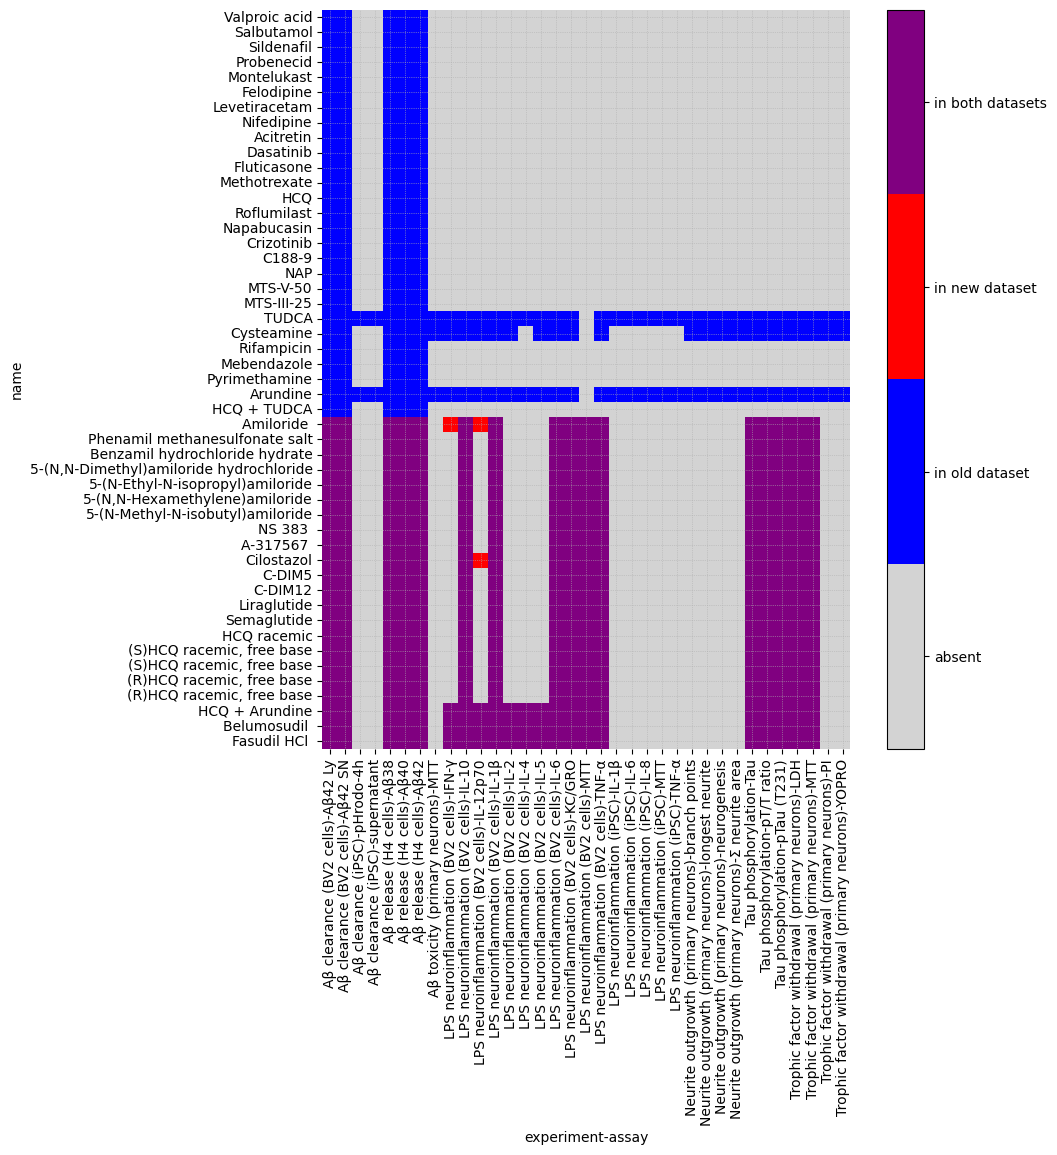

In [22]:
def expand_available_matrix(available, TI2name_df=TI2name_df, all_exper_assay=all_exper_assay):
    df = available['Available'].unstack(level=[1, 2])
    df = df.reindex(pd.MultiIndex.from_frame(TI2name_df.drop('name', axis=1)), axis=0)
    df = df.reindex(pd.MultiIndex.from_frame(all_exper_assay), axis=1)
    df = df.fillna(0)
    return(df)

def my_heatmap_2(data):
    mcmap = matplotlib.colormaps['brg']
    mcmap_colors = mcmap(np.linspace(0, 1, 3))
    gray_colors = np.array([[0.5, 0.5, 0.5, 1]])
    my_cmap = ListedColormap(['lightgray', 'blue', 'red', 'purple'])
    fig, ax = plt.subplots(1, 1, figsize=(9.6, 9.6))
    ax = sns.heatmap(data, ax=ax, cmap=my_cmap, square=True, cbar=False)
    cbar = fig.colorbar(cm.ScalarMappable(cmap=my_cmap), ax=ax, location='right')
    cbar.ax.set_yticks(np.linspace(0.125, 0.875, 4))
    cbar.ax.set_yticklabels(['absent', 'in old dataset', 'in new dataset', 'in both datasets'])
    ax.grid(axis='both', linewidth=0.5, linestyle='dotted')
    return((fig, ax))

available_wide = expand_available_matrix(available_old) + expand_available_matrix(available_new)
fig, ax = my_heatmap_2(pd.DataFrame(available_wide.to_numpy(), index=TI2name_df['name'], columns=available_wide.columns))
attila_utils.savefig(fig, 'presence-in-old-new-datasets')

In [23]:
fpath = '../../results/2024-04-09-qps-results-summary/presence-in-old-new-datasets.xlsx'
df = pd.DataFrame(available_wide.to_numpy(), index=pd.MultiIndex.from_frame(TI2name_df), columns=available_wide.columns)
df = df.map(lambda x: {0: 'absent', 1: 'in old dataset', 2: 'in new dataset', 3: 'in both datasets'}[x])
df.to_excel(fpath)

## Aggregation

(<Figure size 960x960 with 2 Axes>,
 <Axes: xlabel='experiment', ylabel='study-TI-name'>)

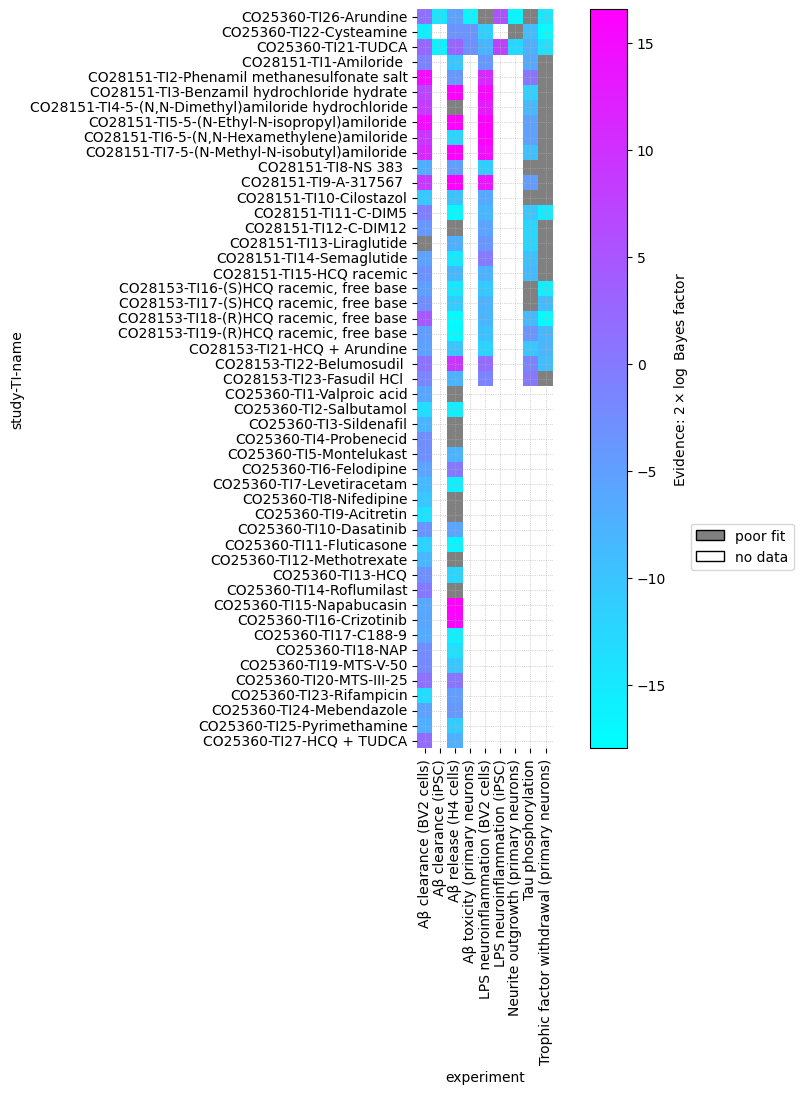

In [24]:
BF10_agg = BF10_wide.groupby('experiment').mean().transpose()
my_heatmap(BF10_agg)

['named-figure/Aβ-clearance-BV2-cells.png',
 'named-figure/Aβ-clearance-BV2-cells.pdf']

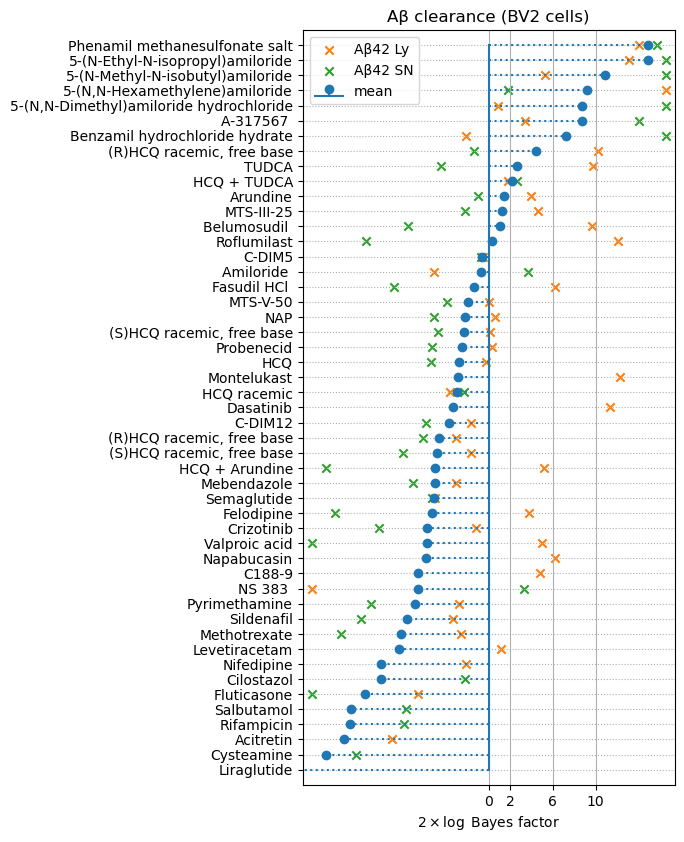

In [25]:
def exper_barplot(experiment='Aβ clearance (BV2 cells)', BF10_wide=BF10_wide, draw_legend=True):
    BF10_agg = BF10_wide.groupby('experiment').mean().transpose()
    df = BF10_wide.xs(experiment, axis=0, level='experiment').transpose()
    df = df.dropna(how='all')
    letters = string.ascii_lowercase[:df.shape[1]]
    assays2letters = dict(zip(df.columns, letters))
    letters2assays = dict(zip(letters, df.columns))
    df = df.rename(assays2letters, axis=1)
    df['average'] = df.mean(axis=1)
    df = df.sort_values('average', ascending=True)
    df_max = df.max().max()
    lim = abs(1.05 * df_max)
    df['name'] = df.index.to_frame()[['name']]
    ys = np.arange(df.shape[0])
    fig, ax = plt.subplots(figsize=(4.8, len(df) / 5))
    ax.stem(df['average'], orientation='horizontal', label='mean', linefmt=':', basefmt='C0-')
    #ax.scatter(y=ys, x=df['average'], marker='o', label='mean')
    #ax.barh(y=ys, width='average', data=df)
    #for c, color in zip(letters, ['C' + str(i + 1) for i in range(len(letters))]):
    my_colors = ['C' + str(i + 1) for i in range(len(letters))]
    my_markers = 10 * ['x'] + 10 * ['+']
    for c, color, marker in zip(letters, my_colors, my_markers):
        s = df[c]
        xs = s.to_list()
        ax.scatter(x=xs, y=ys, marker=marker, c=color, label=letters2assays[c])
        for x, y in zip(xs, ys):
            if x > - lim:
                #ax.text(x=x, y=y, s=c, verticalalignment='center', horizontalalignment='center')
                pass
    ax.set_xlim(- lim, lim)
    ax.set_ylim(- 1, df.shape[0])
    ax.set_title(experiment)
    ax.set_yticks(ys)
    ax.set_yticklabels(df.index.to_frame()['name'].to_list())
    xticks_major = [0, 2, 6, 10]
    xticks_minor = [-2, 1, 4, 8, 12]
    ax.set_xticks(xticks_major, minor=False)
    xticklabels_minor = len(xticks_minor) * ['']
    ax.grid(axis='x')
    ax.grid(axis='y', linestyle='dotted')
    if draw_legend:
        ax.legend()
    ax.set_xlabel(r'$2 \times \log$ Bayes factor')
    return((fig, ax))

experiment = 'Aβ clearance (BV2 cells)'
fig, ax = exper_barplot(experiment)
attila_utils.savefig(fig, re.sub('[ ()]+', '-', experiment).strip('-'))

['named-figure/Aβ-clearance-iPSC.png', 'named-figure/Aβ-clearance-iPSC.pdf']

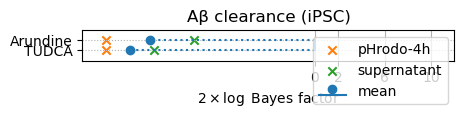

In [26]:
experiment = 'Aβ clearance (iPSC)'
fig, ax = exper_barplot(experiment)
ax.set_xlim(-20, 12)
attila_utils.savefig(fig, re.sub('[ ()]+', '-', experiment).strip('-'))

['named-figure/Aβ-release-H4-cells.png',
 'named-figure/Aβ-release-H4-cells.pdf']

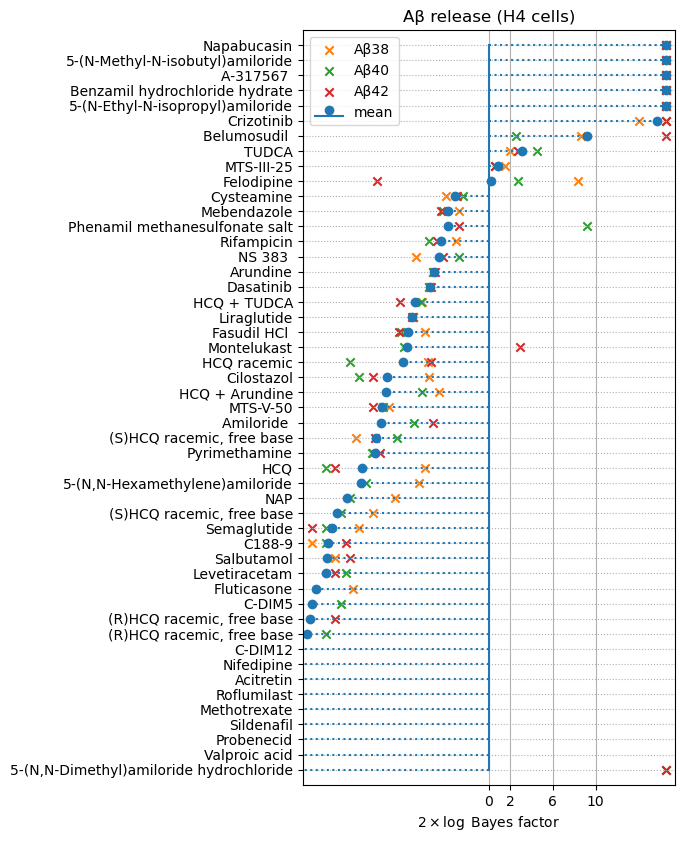

In [27]:
experiment = 'Aβ release (H4 cells)'
fig, ax = exper_barplot(experiment)
attila_utils.savefig(fig, re.sub('[ ()]+', '-', experiment).strip('-'))

['named-figure/Aβ-toxicity-primary-neurons.png',
 'named-figure/Aβ-toxicity-primary-neurons.pdf']

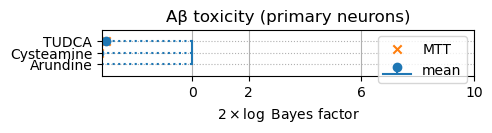

In [28]:
experiment = 'Aβ toxicity (primary neurons)'
fig, ax = exper_barplot(experiment)
attila_utils.savefig(fig, re.sub('[ ()]+', '-', experiment).strip('-'))

['named-figure/LPS-neuroinflammation-BV2-cells.png',
 'named-figure/LPS-neuroinflammation-BV2-cells.pdf']

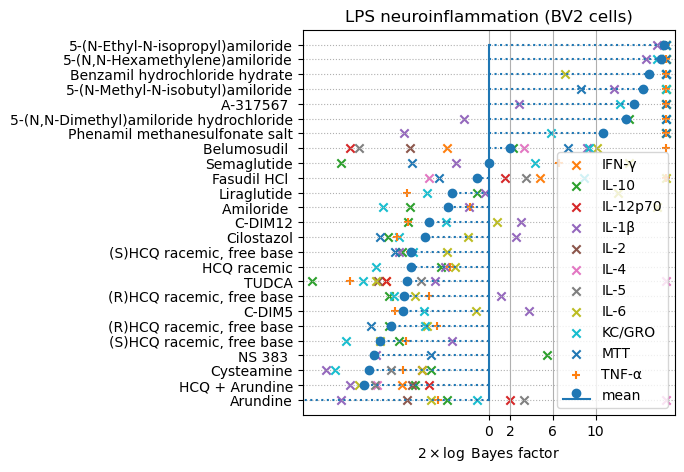

In [29]:
experiment = 'LPS neuroinflammation (BV2 cells)'
fig, ax = exper_barplot(experiment)
attila_utils.savefig(fig, re.sub('[ ()]+', '-', experiment).strip('-'))

['named-figure/LPS-neuroinflammation-iPSC.png',
 'named-figure/LPS-neuroinflammation-iPSC.pdf']

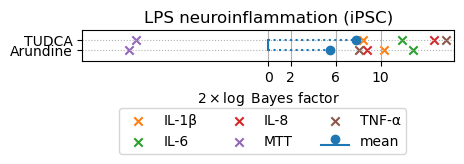

In [30]:
experiment = 'LPS neuroinflammation (iPSC)'
fig, ax = exper_barplot(experiment, draw_legend=False)
fig.legend(ncols=3, loc='upper center', bbox_to_anchor=(0.5, -0.9))
attila_utils.savefig(fig, re.sub('[ ()]+', '-', experiment).strip('-'))

['named-figure/Trophic-factor-withdrawal-primary-neurons.png',
 'named-figure/Trophic-factor-withdrawal-primary-neurons.pdf']

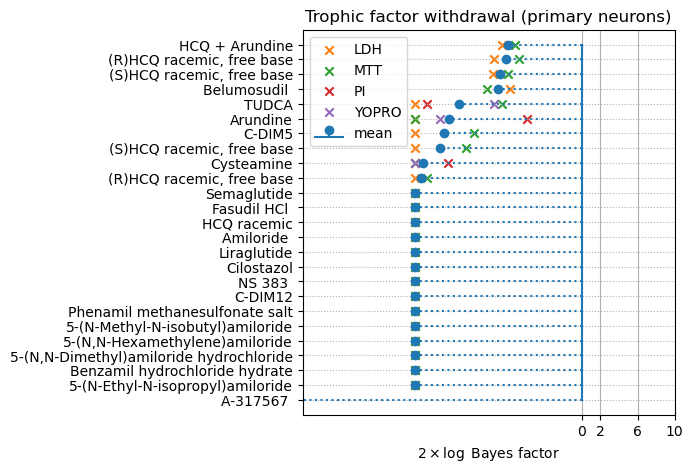

In [33]:
experiment = 'Trophic factor withdrawal (primary neurons)'
fig, ax = exper_barplot(experiment, draw_legend=True)
ax.set_xlim(-30, 10)
#fig.legend(ncols=3, loc='upper center', bbox_to_anchor=(0.5, -0.9))
attila_utils.savefig(fig, re.sub('[ ()]+', '-', experiment).strip('-'))

In [32]:
%connect_info

{
  "shell_port": 59375,
  "iopub_port": 59376,
  "stdin_port": 59377,
  "control_port": 59379,
  "hb_port": 59378,
  "ip": "127.0.0.1",
  "key": "f02b71b3-9cbb8367c65c884eec948ca1",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3",
  "jupyter_session": "/Users/jonesa7/CTNS/notebooks/2024-04-09-qps-results-summary/024-04-09-qps-results-summary.ipynb"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-cbd9784f-b8c4-4aa4-97ec-90d1138858e2.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
